In [3]:
from __future__ import print_function

from matplotlib import pyplot as plt
from tensorflow import keras

from preprocess import create_dataflows_grayscale

image_height = 432
image_width = 768

def preprocess_generator_train_test(generator):
    while True:
        batch = next(generator)
        yield batch, batch

train_ds, test_ds = create_dataflows_grayscale('images/HollowKnight/', (image_height, image_width), 16)
train_ds_prep = preprocess_generator_train_test(train_ds)
test_ds_prep = preprocess_generator_train_test(test_ds)

plt.gray()

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


<Figure size 640x480 with 0 Axes>

(432, 768, 1)
(432, 768, 1)


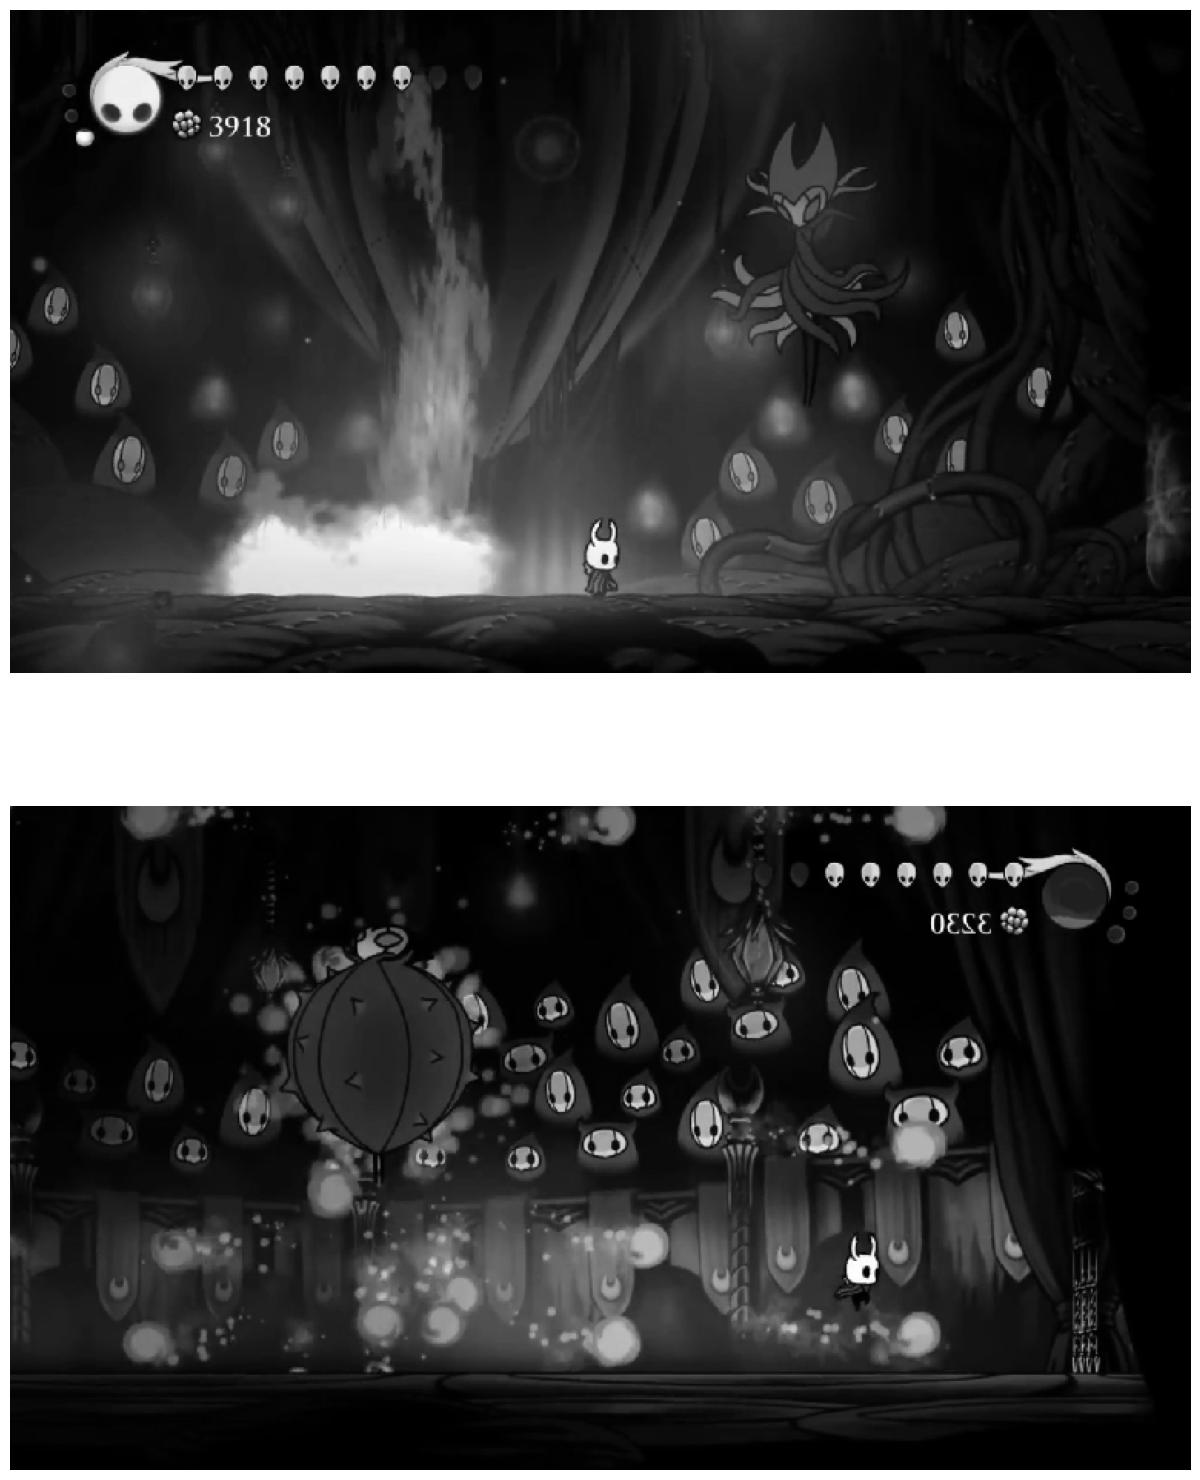

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    print(image.shape)
    plt.imshow(image)
    plt.axis("off")

plt.gray()
train_ds.reset()

In [5]:
import tensorflow
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D
from keras.models import Model

def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

def create_big_compression_model(image_width, image_height):

    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(2, kernel_size=(2, 2), activation='sigmoid', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', dtype='float16')(x)
    print(("shape of encoded", K.int_shape(encoded)))

    # Decoder (upsamling)|
    x = Conv2D(4, kernel_size=(3, 3), activation='sigmoid', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))
    return Model(inputs, decoded)

autoencoder = create_big_compression_model(image_height, image_width)
autoencoder.summary()

autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.005), loss='mae')

('shape of encoded', (None, 108, 192, 4))
('shape of decoded', (None, 432, 768, 1))
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 432, 768, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 432, 768, 2)       10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 384, 2)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 384, 4)       76        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 192, 4)      0         
 2D)                                                             
                                           

In [6]:
autoencoder.fit(train_ds_prep,
                validation_data=test_ds_prep,
                steps_per_epoch=train_ds.n // train_ds.batch_size,
                validation_steps=test_ds.n // test_ds.batch_size,
                epochs=3,
                verbose=1)

Epoch 1/3
212/212 [==============================] - 87s 377ms/step - loss: 0.1985 - val_loss: 0.1516
Epoch 2/3
212/212 [==============================] - 59s 263ms/step - loss: 0.1249 - val_loss: 0.1429
Epoch 3/3
212/212 [==============================] - 81s 381ms/step - loss: 0.1169 - val_loss: 0.1422


1/1 [==============================] - 0s 26ms/step


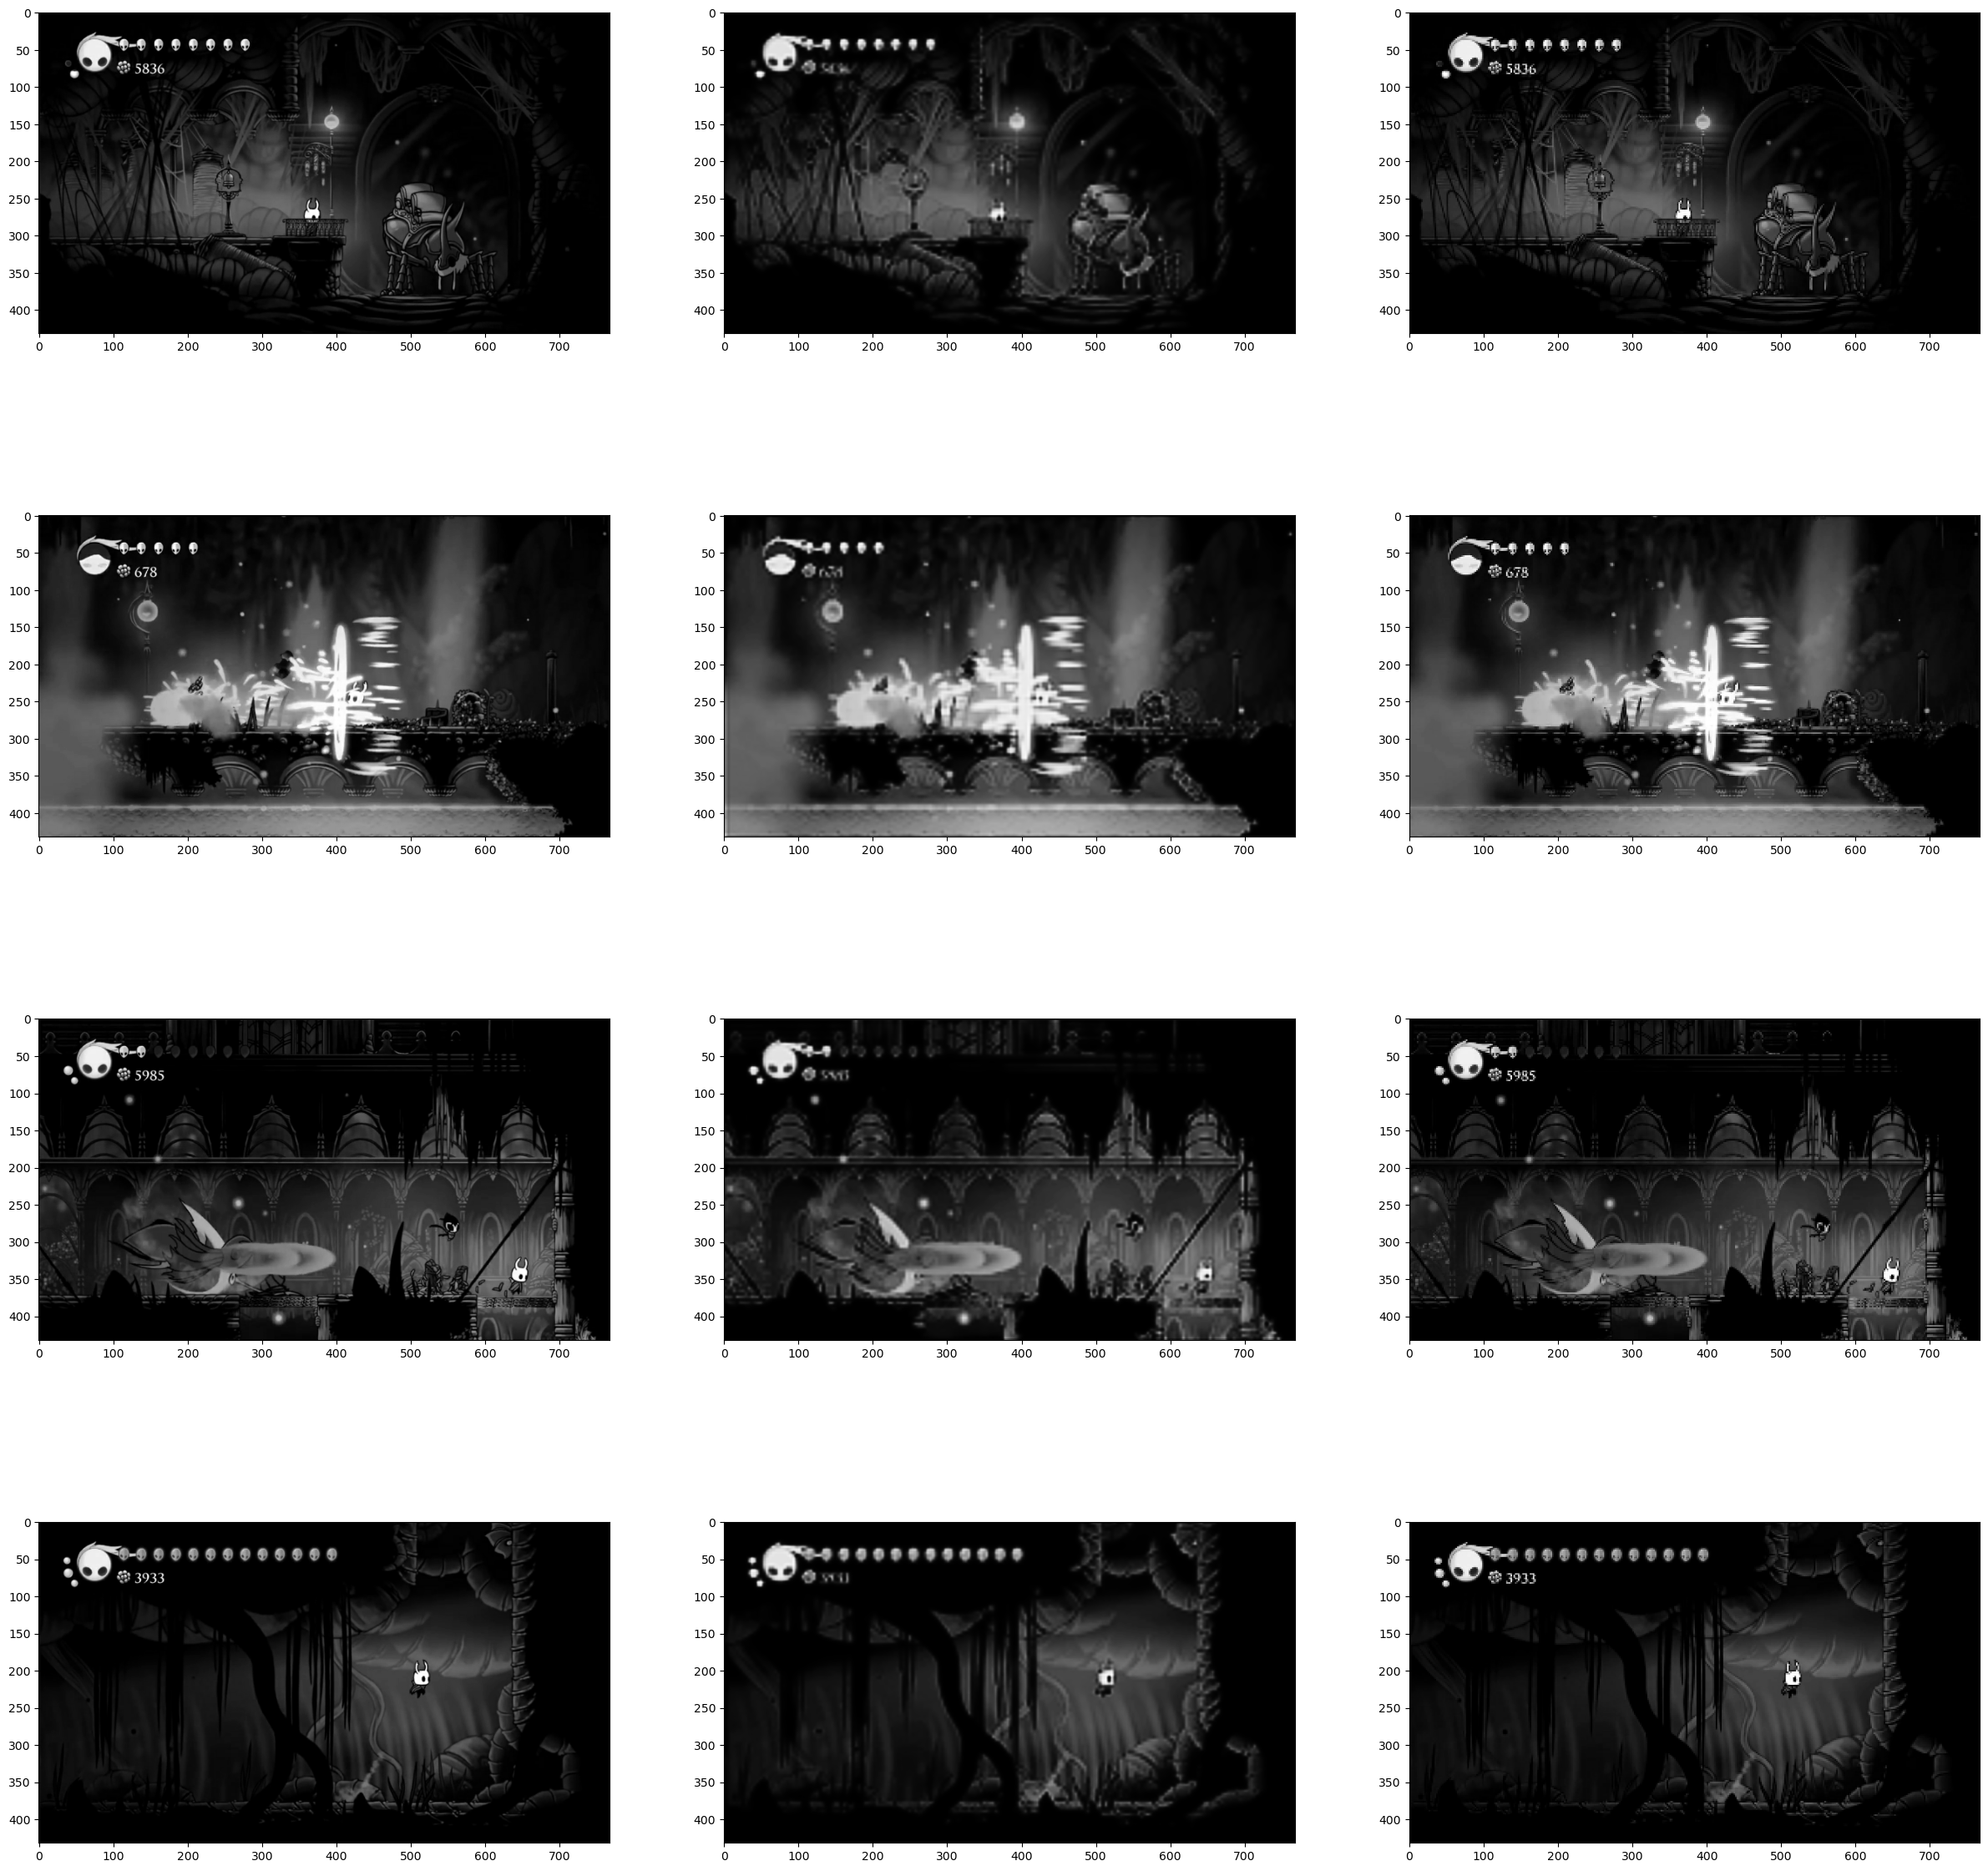

In [9]:


img_number = 4
test_images = [x for x, y in test_ds.take(1)]
test_images = test_images[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    manual_compression = in_img[::2,::2]
    manual_compression = manual_compression.numpy().repeat(2, axis=0).repeat(2, axis=1)
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(manual_compression)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')